# Introduction: Home Credit Default Risk Competition

# Data

Les données sont fournies par Home Credit [Home Credit](http://www.homecredit.net/about-us.aspx), un service dédié à l'octroi de lignes de crédit (prêts) à la population non bancarisée. L'objectif est de prédire si le client remboursera un prêt ou aura des difficultés est un besoin commercial critique,




![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)


application_{train|test}.csv


    Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
    Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

bureau.csv

    Tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
    Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.
    
bureau_balance.csv

    Soldes mensuels des crédits précédents dans Credit Bureau.
    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes .


POS_CASH_balance.csv

    Instantanés du solde mensuel des précédents POS (points de vente) et des prêts en espèces que le demandeur avait avec Home Credit.
    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans laquelle nous avons un historique observable pour les crédits précédents).

credit_card_balance.csv

    Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.
    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour les lignes de carte de crédit précédentes).


previous_application.csv

    Toutes les demandes précédentes de crédit immobilier des clients ayant des crédits dans notre échantillon.
    Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.
    
installments_payments.csv

    Historique de remboursement des crédits précédemment décaissés en Crédit Logement relatifs aux crédits de notre échantillon.
    Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
    Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit Home Credit lié aux crédits de notre échantillon.


https://www.kaggle.com/ganeshn88/home-credit-model

# Chargement des bibliothèques


In [1]:
#numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

from collections import Counter

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

#Model building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb

#Model Evaluation

from sklearn.metrics import roc_auc_score

#Saving Models
#from sklearn.externals import joblib

In [2]:
# List files available
print(os.listdir("../notebook python/projet 7/csv/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


# Présentation des différentes fonctions

# Réduction de l'utilisation de la mémoire

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {: .2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# Importation des données

In [4]:
def importdata():    
    print('-' * 80)
    print('train')
    train = import_data('../notebook python/projet 7/csv/application_train.csv')

    print('-' * 80)
    print('test')
    test = import_data('../notebook python/projet 7/csv/application_test.csv')

    print('-' * 80)
    print('bureau_balance')
    bureau_balance = import_data('../notebook python/projet 7/csv/bureau_balance.csv')

    print('-' * 80)
    print('bureau')
    bureau = import_data('../notebook python/projet 7//csv/bureau.csv')

    print('-' * 80)
    print('credit_card_balance')
    credit_card = import_data('../notebook python/projet 7/csv/credit_card_balance.csv')

    print('-' * 80)
    print('installments_payments')
    installments = import_data('../notebook python/projet 7/csv/installments_payments.csv')

    print('-' * 80)
    print('pos_cash_balance')
    pos_cash = import_data('../notebook python/projet 7/csv/POS_CASH_balance.csv')

    print('-' * 80)
    print('previous_application')
    previous_app = import_data('../notebook python/projet 7/csv/previous_application.csv')
    return train, test, bureau_balance, bureau, credit_card, installments, pos_cash, previous_app

# Traitement des données catégorielles

## Label Encoding (encodage d'étiquettes)

In [5]:

def one_hot_code(app_train, app_test):
    
    app_train = pd.get_dummies(app_train)
    app_test = pd.get_dummies(app_test)
    
    train_labels = app_train['TARGET']
    print('Aligning Train and Test Data')
    app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
    

    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    
    return app_train, app_test, train_labels
    

# Scaling Data (mise à l'échelle des données)

In [6]:
def scale_data(traindata, testdata):
   
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    train = traindata.copy()
    test = testdata.copy()

    imputer.fit(train)
    train = imputer.transform(train)
    test = imputer.transform(test)

    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)

    return train,test


# Feature Engineering

In [7]:
def featureengineering(df):
        
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f)]

    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)

    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)

    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] # ratio montant du crédit du prêt /revenu du client
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY'] # ratio montant du crédit du prêt / rente de prêt (annuité)
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'] # ratio montant du crédit du prêt/ prix des biens pour lesquels le crédit est accordé
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] # ratio rente de prêt(annuité) /revenu du client
    df['NEW_ANNUITY_TO_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # ratio rente de prêt (annuité) / montant du crédit du prêt
    df['NEW_INCOME_TO_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] # ratio revenu du client/ montant du crédit du prêt
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # ratio revenu du client / nb de personnes de la famille du client
    df['NEW_DAYS_EMPLOY_AGE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] # ratio combien de jours avant la demande le client a commencé son emploi actuel / combien de jours avant la demande le client est-il né 
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    
    return df


## Construction du modèle

In [8]:
def preprocess_buildmodel(train,test,cvtype):
    
    train = featureengineering(train)
    test = featureengineering(test)
    
    
    print('--------Encoding Categorical Data----------')
    
    app_train_encoded,app_test_encoded,target = one_hot_code(train, test)
    print('-----------Scaling Data------------------------')
    train_scaled, test_scaled = scale_data(app_train_encoded, app_test_encoded)
    
    print('---------Splitting Data-----------------')

    X_train, X_test, Y_train, Y_test = train_test_split(train_scaled, target, stratify = target, test_size = 0.2, random_state = 1)
    params = {'lr': {"C": np.logspace(-3, 3, 7), "penalty":["l1", "l2"]}}
    models = {'lr': LogisticRegression()}
    
    from collections import defaultdict
    
    model_result = defaultdict(list)
    
    for key in models.keys():
        
        model = models[key]
        param = params[key]
        
        if cvtype == 'grid':
            clf=GridSearchCV(model,param, cv = 5, verbose = 0)
        elif cvtype == 'rand':
            clf = RandomizedSearchCV(model, param, random_state = 1, n_iter = 100, cv=5, verbose = 0, n_jobs = -1)
    
        clf.fit(X_train, Y_train)
        
        print("tuned hpyerparameters :(best parameters) ", clf.best_params_)
        print("accuracy :", clf.best_score_)
        
    
        aucscoretr = roc_auc_score(Y_train, clf.predict_proba(X_train)[: , 1])
        aucscore = roc_auc_score(Y_test, clf.predict_proba(X_test)[: , 1])
        print("roc_auc :", aucscore)

        model_result[key] = clf, clf.best_estimator_.get_params(), aucscoretr, aucscore 
        
    return model_result, X_train, X_test, Y_train, Y_test, test_scaled
    

# Exécution 

# Importation de toutes les données

In [9]:
train, test, bureau_balance, bureau, credit_card, installments, pos_cash, previous_app = importdata()

--------------------------------------------------------------------------------
train
Memory usage of dataframe is  286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is  45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
--------------------------------------------------------------------------------
bureau_balance
Memory usage of dataframe is  624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
--------------------------------------------------------------------------------
bureau
Memory usage of dataframe is  222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
--------------------------------------------------------------------------------
credit_card_balance
Memory usage of dataframe is  673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
----------------------

# Construction du modèle avec seulement Application_Data 

In [11]:

model_result, X_train, X_test, Y_train, Y_test, test_scaled = preprocess_buildmodel(train, test,'rand')

--------Encoding Categorical Data----------
Aligning Train and Test Data
Training Features shape:  (307507, 259)
Testing Features shape:  (48744, 259)
-----------Scaling Data------------------------
Training data shape:  (307507, 259)
Testing data shape:  (48744, 259)
---------Splitting Data-----------------
tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'C': 0.1}
accuracy : 0.9193390378244345
roc_auc : 0.749030752633345


## Combinaison des données importées

In [16]:
#ajout jocelyne
# Days 365.243 values -> nan
previous_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace = True)
# Add feature: value ask / value received percentage
previous_app['APP_CREDIT_PERC'] = previous_app['AMT_APPLICATION'] / previous_app['AMT_CREDIT']
#
prev_apps_avg = previous_app.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
#//
train_prev_app = train.merge(right = prev_apps_avg.reset_index(), how ='left', on='SK_ID_CURR')
# jv
# data = train.append(test)
# train_prev_app = data.merge(right = prev_apps_avg.reset_index(), how ='left', on='SK_ID_CURR')
# fn jv

avg_inst = installments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
train_prev_app_inst = train_prev_app.merge(right=avg_inst.reset_index(), how = 'left', on = 'SK_ID_CURR')

pos_cash = pos_cash.groupby('SK_ID_CURR').mean()
train_prev_app_inst_pos = train_prev_app_inst.merge(right = pos_cash.reset_index(), how ='left', on = 'SK_ID_CURR')

avg_cc_bal = credit_card.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
train_prev_app_inst_pos_credit = train_prev_app_inst_pos.merge(right = avg_cc_bal.reset_index(), how = 'left', on = 'SK_ID_CURR')

# bureau_avg = bureau.groupby('SK_ID_CURR').mean()
# bureau_avg.columns = ['B_' + f_ for f_ in bureau_avg.columns]
# train_prev_app_inst_pos_credit_bureau = train_prev_app_inst_pos_credit.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
# ajout jv
bureau_balance_avg = bureau_balance.groupby("SK_ID_BUREAU").mean()
bureau_balance_avg.columns = ['BB_' + f_ for f_ in bureau_balance_avg.columns]
bureau_bb =  bureau.merge(right = bureau_balance_avg, how = "left", on = "SK_ID_BUREAU")
bureau_bb.drop(['SK_ID_BUREAU'], axis = 1, inplace = True)
bureau_bb
#
bureau_avg = bureau_bb.groupby('SK_ID_CURR').mean()
bureau_avg.columns = ['B_' + f_ for f_ in bureau_avg.columns]
train_prev_app_inst_pos_credit_bureau = train_prev_app_inst_pos_credit.merge(right = bureau_avg.reset_index(), how = 'left', on = 'SK_ID_CURR')


In [17]:
app_train = train_prev_app_inst_pos_credit_bureau
app_test = test

#

In [18]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'B_DAYS_ENDDATE_FACT', 'B_AMT_CREDIT_MAX_OVERDUE',
       'B_CNT_CREDIT_PROLONG', 'B_AMT_CREDIT_SUM', 'B_AMT_CREDIT_SUM_DEBT',
       'B_AMT_CREDIT_SUM_LIMIT', 'B_AMT_CREDIT_SUM_OVERDUE',
       'B_DAYS_CREDIT_UPDATE', 'B_AMT_ANNUITY', 'B_BB_MONTHS_BALANCE'],
      dtype='object', length=190)

# Exécution du modèle sans tenir compte du déséquilibre des données

In [19]:
#app_train = train_prev_app_inst_pos_credit_bureau.sample(data_size)
app_train = train_prev_app_inst_pos_credit_bureau
app_test = test
print('Shape', app_train.shape)
model_result, X_train, X_test, Y_train, Y_test, test_scaled = preprocess_buildmodel(app_train, app_test, 'rand')

Shape (307511, 190)
--------Encoding Categorical Data----------
Aligning Train and Test Data
Training Features shape:  (307507, 259)
Testing Features shape:  (48744, 259)
-----------Scaling Data------------------------
Training data shape:  (307507, 259)
Testing data shape:  (48744, 259)
---------Splitting Data-----------------
tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'C': 0.1}
accuracy : 0.9193552976565517
roc_auc : 0.7491119086590907


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression( random_state=0, C = 0.1, penalty = "l2").fit(X_train, Y_train)

# clf = model_result['lr'][0]

print("accuracy :", clf.score(X_test, Y_test))
        
    
aucscoretr = roc_auc_score(Y_train, clf.predict_proba(X_train)[:, 1])
aucscore = roc_auc_score(Y_test, clf.predict_proba(X_test)[:, 1])
print("roc_auc :", aucscore)


predicts = clf.predict(X_train)
confusion_matrix(Y_train, predicts)

accuracy : 0.9194497739910897
roc_auc : 0.7491119086590907


array([[226018,    127],
       [ 19704,    156]], dtype=int64)

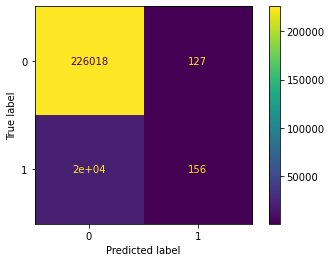

In [21]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_train, Y_train) 

In [22]:
from sklearn.metrics import precision_score, recall_score, classification_report

print("Precision:", precision_score(Y_train, predicts))
print("Recall:", recall_score(Y_train, predicts))

Precision: 0.5512367491166078
Recall: 0.00785498489425982


Le recall c'est la proportion de positif que l'on a correctement identifié.
La précision c'est la proportion de prédiction correcte parmi les points que l'on a prédit positif.

In [23]:
print(classification_report(Y_train, predicts))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226145
           1       0.55      0.01      0.02     19860

    accuracy                           0.92    246005
   macro avg       0.74      0.50      0.49    246005
weighted avg       0.89      0.92      0.88    246005



# Courbe ROC

Text(0.5, 1.0, 'ROC Curve on the Test Set')

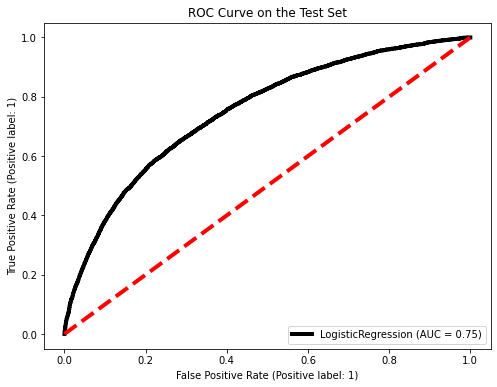

In [24]:
from sklearn import metrics

fig, ax = plt.subplots(figsize=(8, 6))
metrics.plot_roc_curve(clf, X_test, Y_test, ax = ax, color = 'black', lw=4)
ax.plot([0, 1], linestyle = '--', lw = 4, color = 'red')
ax.set_title('ROC Curve on the Test Set')


Plus la courbe bleue penche vers le coin supérieur gauche (angle droit), mieux un modèle prédit les résultats réels.

# Application de méthodes de rééchantillonnage pour pallier au déséquilibre des données

## Utilisation des méthodes de rééchantillonnage

Modifier l’ensemble de données que vous utilisez avant d’entraîner votre modèle prédictif afin d’avoir des données plus équilibrées.

Cette stratégie est appelée rééchantillonnage et il existe deux méthodes principales que vous pouvez utiliser pour égaliser les classes : 

Le sur-échantillonnage : Oversampling et le sous-échantillonnage :Undersampling. 

* Les méthodes d’Oversampling fonctionnent en augmentant le nombre d’observations de la (des) classe(s) minoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.

* Les méthodes d’Undersampling fonctionnent en diminuant le nombre d’observations de la  (des) classe(s) majoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.


* Privilégiez le sous-échantillonnage lorsque vous disposez de grands jeux de données : des dizaines ou des centaines de milliers de cas ou plus.
* Privilégiez le sur-échantillonnage lorsque vous ne disposez pas de beaucoup de données :des dizaines de milliers ou moins.

In [25]:
def reechantillonnage_model_lr(X_re, y_re, X_train, y_train, X_test, y_test):
    '''
    En entrée :
    X_re : 
    y_re :
    X_train :
    y_train :
    X_test :
    y_test :
    En sortie
    clf :
    '''
    
    params={'lr': {"C": np.logspace(-3,3,7), "penalty": ["l1","l2"]} }
    models = {'lr': LogisticRegression()}
    clf = GridSearchCV(models['lr'], params['lr'], cv = 5, verbose = 0)
    clf.fit(X_re, y_re)
        
    print("tuned hyperparameters :(best parameters) ", clf.best_params_)
    print("accuracy :", clf.best_score_)
        

    y_pred = clf.predict(X_test)
    print(classification_report_imbalanced(Y_test, y_pred))


#     print("accuracy :",clf.score(X_test, y_test))


    plot_confusion_matrix(clf, X_train, y_train) 
    
    aucscoretr = roc_auc_score(y_train, clf.predict_proba(X_train)[: , 1])
    aucscore = roc_auc_score(y_test, clf.predict_proba(X_test)[: , 1])
    print("roc_auc :", aucscore)

    fig, ax = plt.subplots(figsize=(8, 6))
    metrics.plot_roc_curve(clf, X_test, y_test, ax = ax, color = 'black', lw = 4)
    ax.plot([0, 1], linestyle = '--', lw = 4, color = 'red')
    ax.set_title('ROC Curve on the Test Set')
    return clf

tuned hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.6834088620342397
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.68      0.68      0.80      0.68      0.46     56537
          1       0.16      0.68      0.68      0.26      0.68      0.46      4965

avg / total       0.90      0.68      0.68      0.75      0.68      0.46     61502

roc_auc : 0.7493659714433458


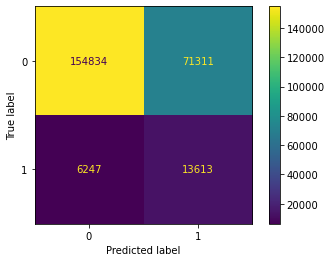

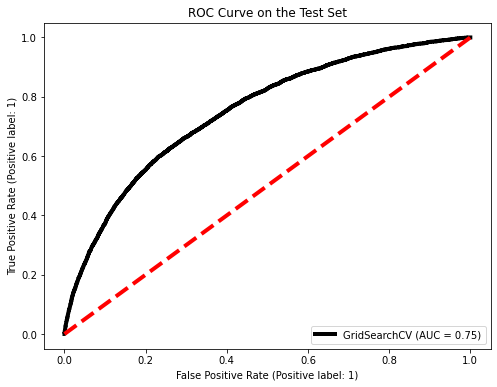

In [26]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# Sous-échantillonnage
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, Y_train)
# Entraînement du modèle de régression logistique

clf_1 = reechantillonnage_model_lr(X_ru, y_ru, X_train, Y_train, X_test, Y_test)


## La génération d’échantillons synthétiques


Il existe des algorithmes pour générer des échantillons synthétiques de manière automatique. Le plus populaire de ces algorithmes est SMOTE (pour Synthetic Minority Over-sampling Technique). Comme son nom l’indique, SMOTE est une méthode de sur-échantillonnage. Elle fonctionne en créant des échantillons synthétiques à partir de la classe minoritaire au lieu de créer de simples copies. 


tuned hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.7115722213624001
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.70      0.65      0.81      0.68      0.46     56537
          1       0.16      0.65      0.70      0.26      0.68      0.46      4965

avg / total       0.89      0.70      0.66      0.77      0.68      0.46     61502

roc_auc : 0.740086069704088


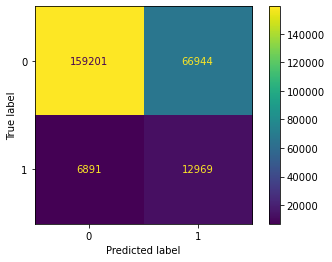

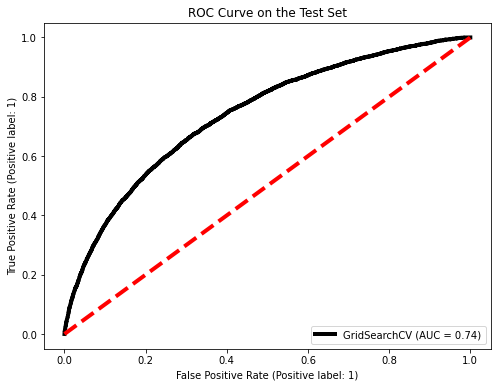

In [27]:
from imblearn.over_sampling import SMOTE 

# SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, Y_train)

clf_2 = reechantillonnage_model_lr(X_sm, y_sm, X_train, Y_train, X_test, Y_test)


References:

Reducing Memory usage  - https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

Notebook de référence : https://www.kaggle.com/ganeshn88/home-credit-model